# Reinforcement Learning

This tutorial will walk through some initial concepts and algorithms for reinforcement learning (RL). I'll assume you've already done the general introduction on supervised learning with Tensorflow. We'll start with basic Q-learning to introduce the concept of RL, but you will need to be familiar with Tensorflow models for some of the later algorithms.

Additionally, the focus of this tutorial will be on RL in control applications. We'll start by introducing the cartpole problem.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym
import time

from IPython import display

%matplotlib inline

## Loading Gym Environments

OpenAI's Gym has a range of environments designed for RL experiments load in and use out-of-the-box. These environments include a simple cartpole problem. This environment gives the position and velocity of the cart and the angle and angular rate of the pendulum as the observation. There are two possible actions for the agent: push left or push right. The agent receives a reward of +1 every time step until the cart position or pendulum angle pass a given threshold. 

In [2]:
env = gym.make("CartPole-v1")

print("Observation:", env.observation_space)
print("Action:", env.action_space)

Observation: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action: Discrete(2)


We can quickly visualize this environment to see how an agent is performing. Since we don't yet have an agent, we'll just sample actions randomly. Of course, this policy won't last long before failing.

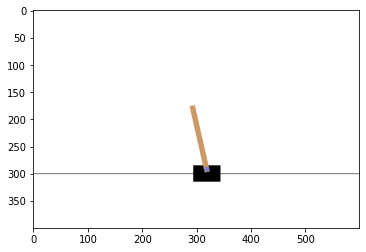

In [3]:
env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
done = False
while not done:
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
env.close()

## Q-Learning

We start by solving this algorithm with Q-learning. This isn't a *Deep* RL algorithm, but it provides a more clear example of the principles that later algorithms will be working off of. 

The objective of Q-Learning (and many algorithms we explore later) is to learn a function to predict the value for taking an action at a given state. In mathematical terms, $Q : S \times A \rightarrow \mathbb{R}$ where $S$ is the state space $A$ is the action space. 

Regular Q-Learning represents this function as a look-up table and learns each value through dynamic programming. Experience is sampled from the environment in the for $(s_t, a_t, s_{t+1})$. Each time new experience is sampled, the Q value is updated by the equation:

$Q_{i+1}(s_t, a_t) \leftarrow R(s_t, a_t, s_{t+1}) + \gamma \max_a Q_i(s_{t+1}, a)$

This is the sum of the immediate rewards, $R(s_t, a_t, s_{t+1})$, and the future rewards estimated by the Q function discounted by some $\gamma$ between 0 and 1. 

Since the state space of the cartpole is continuous, we need to discretize it before we can build a Q table.

In [4]:
x = np.arange(-6, 5, 2)
xdot = np.array([-np.inf, -1, -.5, 0, .5, 1])
theta = np.arange(-0.42, .42, .21)
thetadot = np.array([-np.inf, -.1, -.05, 0, .05, .1])

print("x:", x)
print("theta:", theta)
print("thetadot:", thetadot)
print("xdot:", xdot)

N = x.shape[0]*xdot.shape[0]*theta.shape[0]*thetadot.shape[0]

Q = np.zeros((N,2))

def q_map(obs):
    i = np.nonzero(x <= obs[0])[0][-1]
    j = np.nonzero(xdot <= obs[1])[0][-1]
    k = np.nonzero(theta <= obs[2])[0][-1]
    l = np.nonzero(thetadot <= obs[3])[0][-1]
    
    return l + (k + (j + i*xdot.shape[0])*theta.shape[0])*thetadot.shape[0]

x: [-6 -4 -2  0  2  4]
theta: [-0.42 -0.21  0.    0.21]
thetadot: [ -inf -0.1  -0.05  0.    0.05  0.1 ]
xdot: [-inf -1.  -0.5  0.   0.5  1. ]


In [5]:
print(q_map(np.array([-4.5, -2, -.4, -.2])))
print(q_map(np.array([-4.5, -2, -.4, -.08])))
print(q_map(np.array([-4.5, -2, -.1, -.2])))
print(q_map(np.array([-4.5, -.8, -.4, -.2])))
print(q_map(np.array([-2.5, -2, -.4, -.2])))

0
1
6
24
144


Now we just need to collect some experience and update our Q function until it converges on a successful policy. Feel free to run the following cell a few times until the total return is at a satisfactory value. (Note this probably won't acheive a particularly high score. Just train it until it can reach a score of 100 every once in a while).

In [10]:
for i in range(100):
    print("Episode", i)
    obs = env.reset()
    total_return = 0
    done = False
    while not done:
        ind = q_map(obs)
        if np.random.rand() > .1:
            action = np.argmax(Q[ind])
        else:
            action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)
        total_return += reward

        Q[ind, action] = reward + 0.99 * np.max(Q[q_map(obs)])
    print("Total return:", total_return)

env.close()

Episode 0
Total return: 27.0
Episode 1
Total return: 13.0
Episode 2
Total return: 37.0
Episode 3
Total return: 47.0
Episode 4
Total return: 18.0
Episode 5
Total return: 31.0
Episode 6
Total return: 16.0
Episode 7
Total return: 81.0
Episode 8
Total return: 24.0
Episode 9
Total return: 32.0
Episode 10
Total return: 32.0
Episode 11
Total return: 46.0
Episode 12
Total return: 26.0
Episode 13
Total return: 30.0
Episode 14
Total return: 29.0
Episode 15
Total return: 12.0
Episode 16
Total return: 11.0
Episode 17
Total return: 46.0
Episode 18
Total return: 23.0
Episode 19
Total return: 32.0
Episode 20
Total return: 73.0
Episode 21
Total return: 47.0
Episode 22
Total return: 38.0
Episode 23
Total return: 39.0
Episode 24
Total return: 9.0
Episode 25
Total return: 13.0
Episode 26
Total return: 12.0
Episode 27
Total return: 75.0
Episode 28
Total return: 28.0
Episode 29
Total return: 30.0
Episode 30
Total return: 112.0
Episode 31
Total return: 22.0
Episode 32
Total return: 43.0
Episode 33
Total ret

Now that we've trained a Q function we can visualize how well it performs.

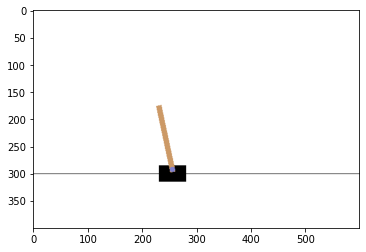

In [11]:
obs = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
done = False
while not done:
    ind = q_map(obs)
    if np.random.rand() > .1:
        action = np.argmax(Q[ind])
    else:
        action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)

    Q[ind, action] = reward + 0.99 * np.max(Q[q_map(obs)])

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
env.close()